In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from division_aggregation_function import division_aggregation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer

In [4]:
data = pd.read_csv("index.csv")
hosp = pd.read_csv("hospitalizations.csv")
epi = pd.read_csv("epidemiology.csv")
vax = pd.read_csv("vaccinations.csv")
emrg = pd.read_csv("lawatlas-emergency-declarations.csv")
weather = pd.read_csv('weather.csv')
govresp = pd.read_csv('oxford-government-response.csv')

In [6]:
epi_us = epi[epi.location_key.isin(data[data.country_name == 'United States of America'].location_key)]
hosp_us = hosp[hosp.location_key.isin(data[data.country_name == 'United States of America'].location_key)]
vax_us = vax[vax.location_key.isin(data[data.country_name == 'United States of America'].location_key)]
emrg_us = emrg[emrg.location_key.isin(data[data.country_name == 'United States of America'].location_key)]
weather_us = weather[weather.location_key.isin(data[data.country_name == 'United States of America'].location_key)]
govresp_us = govresp[govresp.location_key.isin(data[data.country_name == 'United States of America'].location_key)]

In [7]:
terrs = ['US', 'AS', 'GU', 'MP', 'PR', 'VI']
epi_f = epi_us[(epi_us.location_key.str.len() <= 5) & ~(epi_us.location_key.isin(terrs))]
hosp_f = hosp_us[(hosp_us.location_key.str.len() <= 5) & ~(hosp_us.location_key.isin(terrs))]
vax_f = vax_us[(vax_us.location_key.str.len() <= 5) & ~(vax_us.location_key.isin(terrs))]
emrg_f = emrg_us[(emrg_us.location_key.str.len() <= 5) & ~(emrg_us.location_key.isin(terrs))]
weather_f = weather_us[(weather_us.location_key.str.len() <= 5) & ~(weather_us.location_key.isin(terrs))]
govresp_f = govresp_us[(govresp_us.location_key.str.len() <= 5) & ~(govresp_us.location_key.isin(terrs))]

In [28]:
data_all = pd.merge(epi_f, hosp_f, on=['date', 'location_key']).merge(vax_f, on=['date', 'location_key']).merge(weather_f, on=['date', 'location_key']).merge(govresp_f, on=['date', 'location_key'])

In [232]:
data_all.to_csv('covid_data1.csv')

In [253]:
data_all = pd.read_csv('/Users/RJS/Desktop/STAT 390/Stat390-Project/data/covid_data1.csv')
data_all['region'] = data_all['location_key'].apply(division_aggregation)
data_all = data_all[data_all.columns[(data_all.isna().sum()/len(data_all) <= 0.1).values]]

In [58]:
datanum = data_all.select_dtypes(include = [np.number]).copy()
mice = IterativeImputer(max_iter = 50, random_state = 0)
imputedvals = mice.fit_transform(datanum)
imputed_datanum = pd.DataFrame(imputedvals, columns = datanum.columns)

In [254]:
datanum = data_all.select_dtypes(include = [np.number]).copy()
knn = KNNImputer(n_neighbors = 50)
imputedvals = knn.fit_transform(datanum)
knn_datanum = pd.DataFrame(imputedvals, columns = datanum.columns)

In [255]:
data_all.new_persons_fully_vaccinated_pfizer.isna().sum()

2694

In [256]:
knn_datanum.isna().sum()

Unnamed: 0                                       0
new_confirmed                                    0
new_deceased                                     0
cumulative_confirmed                             0
cumulative_deceased                              0
new_hospitalized_patients                        0
cumulative_hospitalized_patients                 0
current_hospitalized_patients                    0
current_intensive_care_patients                  0
new_persons_vaccinated                           0
cumulative_persons_vaccinated                    0
new_persons_fully_vaccinated                     0
cumulative_persons_fully_vaccinated              0
new_vaccine_doses_administered                   0
cumulative_vaccine_doses_administered            0
new_persons_fully_vaccinated_pfizer              0
cumulative_persons_fully_vaccinated_pfizer       0
new_vaccine_doses_administered_pfizer            0
cumulative_vaccine_doses_administered_pfizer     0
new_persons_fully_vaccinated_mo

(array([21642.,  1657.,   644.,   321.,   205.,   130.,   106.,    71.,
           51.,    36.]),
 array([    0.,  1000.,  2000.,  3000.,  4000.,  5000.,  6000.,  7000.,
         8000.,  9000., 10000.]),
 <BarContainer object of 10 artists>)

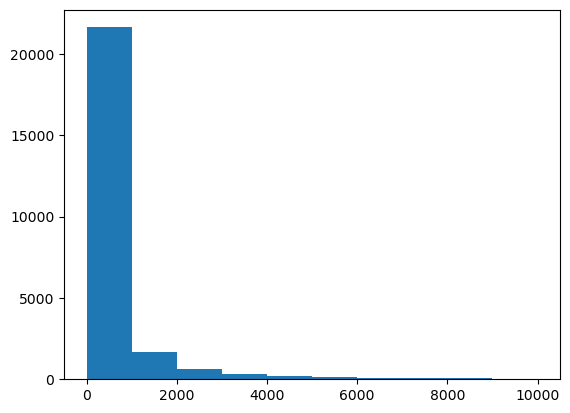

In [257]:
plt.hist(data_all.new_persons_fully_vaccinated_janssen, range = (0, 10000))

(array([ 105.,   20.,   15., 1431.,  745.,  247.,  106.,   50.,   22.,
          16.]),
 array([    0.,  1000.,  2000.,  3000.,  4000.,  5000.,  6000.,  7000.,
         8000.,  9000., 10000.]),
 <BarContainer object of 10 artists>)

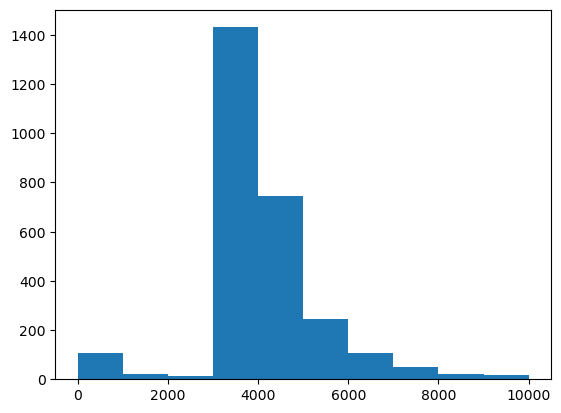

In [258]:
plt.hist(imputed_datanum[data_all.isna().any(axis = 1)].new_persons_fully_vaccinated_janssen, range = (0, 10000))

(array([1750.,  575.,  294.,   49.,   49.,   34.,    8.,    4.,    4.,
           4.]),
 array([    0.,  1000.,  2000.,  3000.,  4000.,  5000.,  6000.,  7000.,
         8000.,  9000., 10000.]),
 <BarContainer object of 10 artists>)

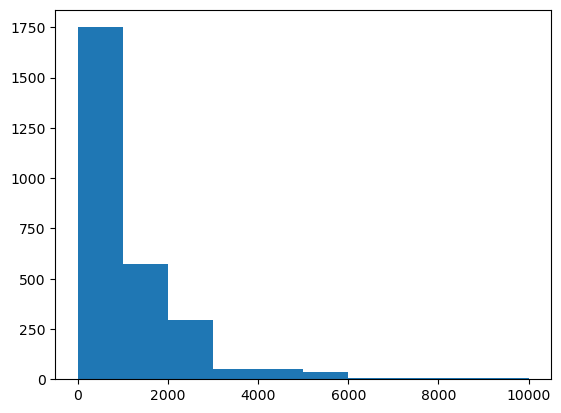

In [259]:
plt.hist(knn_datanum[data_all.isna().any(axis = 1)].new_persons_fully_vaccinated_janssen, range = (0, 10000))

In [260]:
# missingmask = data_all.select_dtypes(include = [np.number]).isna()
# data_all.select_dtypes(include = [np.number])[missingmask] = knn_datanum[missingmask]
datacopy2 = data_all.mask(data_all.isna(), other = knn_datanum)

In [261]:
for i in data_all.columns[3:-1]:
    for j in range(0, data_all.shape[0]):
        if np.isnan(data_all.loc[j, i]):
            data_all.loc[j, i] = knn_datanum.loc[j, i]

In [262]:
data_all.equals(datacopy2)

True

In [263]:
numofstates = {
    "New England": 6,
    "Mid-Atlantic": 3,
    "East North Central": 5,
    "West North Central": 7,
    "South Atlantic": 9,
    "East South Central": 4,
    "West South Central": 4,
    "Mountain": 8,
    "Pacific": 5
}

In [264]:
grouped = data_all.groupby(['region', 'date'])
groupsizes = grouped.size()

In [269]:
def groupfilter(group):
    region = group.name[0]
    numstates = numofstates[region]
    return group['location_key'].nunique() == numstates

In [270]:
filtered_data = data_all.groupby(['region', 'date']).filter(groupfilter)

In [272]:
filtered_data.groupby(['region', 'date']).size()

region              date      
East North Central  2021-01-12    5
                    2021-01-13    5
                    2021-01-14    5
                    2021-01-15    5
                    2021-01-19    5
                                 ..
West South Central  2022-06-30    4
                    2022-07-01    4
                    2022-07-02    4
                    2022-07-03    4
                    2022-07-04    4
Length: 4811, dtype: int64

In [273]:
grouped = filtered_data.groupby(['region', 'date'])

In [275]:
regional_multi = grouped.agg({'new_confirmed': 'sum', 'new_deceased': 'sum',
       'cumulative_confirmed': 'sum', 'cumulative_deceased': 'sum', 
       'new_hospitalized_patients': 'sum', 'cumulative_hospitalized_patients': 'sum',
       'current_hospitalized_patients': 'sum', 'current_intensive_care_patients': 'sum',
       'new_persons_vaccinated': 'sum', 'cumulative_persons_vaccinated': 'sum',
       'new_persons_fully_vaccinated': 'sum', 'cumulative_persons_fully_vaccinated': 'sum',
       'new_vaccine_doses_administered': 'sum',
       'cumulative_vaccine_doses_administered': 'sum',
       'new_persons_fully_vaccinated_pfizer': 'sum',
       'cumulative_persons_fully_vaccinated_pfizer': 'sum',
       'new_vaccine_doses_administered_pfizer': 'sum',
       'cumulative_vaccine_doses_administered_pfizer': 'sum',
       'new_persons_fully_vaccinated_moderna': 'sum',
       'cumulative_persons_fully_vaccinated_moderna': 'sum',
       'new_vaccine_doses_administered_moderna': 'sum',
       'cumulative_vaccine_doses_administered_moderna': 'sum',
       'new_persons_fully_vaccinated_janssen': 'sum',
       'cumulative_persons_fully_vaccinated_janssen': 'sum',
       'new_vaccine_doses_administered_janssen': 'sum',
       'cumulative_vaccine_doses_administered_janssen': 'sum',
       'rainfall_mm': 'sum', 
       'average_temperature_celsius': 'mean', 'dew_point': 'mean',
       'relative_humidity': 'mean', 'school_closing': 'mean', 'workplace_closing': 'mean',
       'cancel_public_events': 'mean', 'restrictions_on_gatherings': 'mean',
       'public_transport_closing': 'mean', 'stay_at_home_requirements': 'mean',
       'restrictions_on_internal_movement': 'mean', 'international_travel_controls': 'mean',
       'income_support': 'mean', 'debt_relief': 'mean', 'public_information_campaigns': 'mean',
       'testing_policy': 'mean', 'contact_tracing': 'mean', 'facial_coverings': 'mean',
       'vaccination_policy': 'mean', 'stringency_index': 'mean', 
       'minimum_temperature_celsius': 'min', 
       'maximum_temperature_celsius': 'max'})

In [276]:
regional_multi

new_confirmed  new_deceased  \
region             date                                      
East North Central 2021-01-12        23537.0         484.0   
                   2021-01-13        22104.0         344.0   
                   2021-01-14        25116.0         479.0   
                   2021-01-15        24164.0         341.0   
                   2021-01-19        16287.0         312.0   
...                                      ...           ...   
West South Central 2022-06-30        23453.0          34.0   
                   2022-07-01        16403.0          32.0   
                   2022-07-02         1403.0           4.0   
                   2022-07-03          165.0           0.0   
                   2022-07-04          736.0           0.0   

                               cumulative_confirmed  cumulative_deceased  \
region             date                                                    
East North Central 2021-01-12             3528982.0              58332.0   
                   2021-01-13             3551086.0              58676.0   
                   2021-01-14             3576202.0              59155.0   
                   2021-01-15             3600366.0              59496.0   
                   2021-01-19             3666739.0              60663.0   
...                                             ...                  ...   
West South Central 2022-06-30            10355924.0             132366.0   
                   2022-07-01            10372327.0             132398.0   
                   2022-07-02            10373730.0             132402.0   
                   2022-07-03            10373895.0             132402.0   
                   2022-07-04            10374631.0             132402.0   

                               new_hospitalized_patients  \
region             date                                    
East North Central 2021-01-12                     1921.0   
                   2021-01-13                     1738.0   
                   2021-01-14                     1790.0   
                   2021-01-15                     1742.0   
                   2021-01-19                     1589.0   
...                                                  ...   
West South Central 2022-06-30                      764.0   
                   2022-07-01                      728.0   
                   2022-07-02                      742.0   
                   2022-07-03                      634.0   
                   2022-07-04                      660.0   

                               cumulative_hospitalized_patients  \
region             date                                           
East North Central 2021-01-12                          224040.0   
                   2021-01-13                          225778.0   
                   2021-01-14                          227568.0   
                   2021-01-15                          229310.0   
                   2021-01-19                          235348.0   
...                                                         ...   
West South Central 2022-06-30                          768539.0   
                   2022-07-01                          769267.0   
                   2022-07-02                          770009.0   
                   2022-07-03                          770643.0   
                   2022-07-04                          771303.0   

                               current_hospitalized_patients  \
region             date                                        
East North Central 2021-01-12                        12855.0   
                   2021-01-13                        12605.0   
                   2021-01-14                        12260.0   
                   2021-01-15                        12089.0   
                   2021-01-19                        11388.0   
...                                                      ...   
West South Central 2022-06-30                         3535.0   
      

In [278]:
regional_multi.to_csv('../data/regional_multivariate_data.csv')